# Training a model with DiscoEPG

In DiscoEPG, we provide *trainer* objects that allow the users to train a ML model with their custom dataset, namely `EPGSegment` and `EPGSegmentML`. While `EPGSegment` supports training deep learning models such as `1DCNN`, `2DCNN` or `ResNet`, `EPGSegmentML` supports `scikit-learn` traditional ML models, i.e., `XGB`, `Random Forest` and `Logistic Regression`. \
We suggest the users to use `CNN1D` with raw input or `XGB` with wavelet transform features for initial experiments thanks to their rapid training speed and competitive predicition accuracy.

In [2]:
# Autoreload utilities
%load_ext autoreload
%autoreload 2

# Importing trainer objects
from models.Segmentation import EPGSegment
from models.SegmentationML import EPGSegmentML

## DiscoEPG
Support 1DCNN, ResNet, 2DCNN

## Training and evaluation

Each trainer will get the model settings from a config file (.json), which has to be preprocessed to a Python dictionary

In [51]:
# Model configurations
from utils.configs_utils import process_config
config = process_config('cnn1d.soybeanAphid.raw.256.json')
config 
# You can create/adjust the *.json configuration files in the configs folder "./DiscoEPG/configs/your_config_files.json"

{'exp_name': 'Soybean_Aphid',
 'dataset_name': 'soybeanAphid',
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'cnn1d',
 'method': 'raw',
 'scale': True,
 'outlier_filter': False,
 'optimizer': 'Adam',
 'n_epochs': 50,
 'lr': 0.0001,
 'batch_size': 256,
 'scope': 1,
 'data_path': '../data',
 'device': 'cpu',
 'timestamp': '2024-08-09 15:57:14'}

In [52]:
# Call the trainer
epgs = EPGSegment(config)

Loading data ...


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


Done! Elapsed: 23.091740800009575 s


In [55]:
# Train
epgs.train(early_stop=False)

Obtaining dataloders ...
Generating sliding windows ...


100%|██████████| 32/32 [00:06<00:00,  5.30it/s]


Total: 32 recordings
Signal processing method: raw | Scale: True
Class distribution (label:ratio): 1: 0.31, 2: 0.22, 4: 0.01, 5: 0.08, 6: 0.04, 7: 0.14, 8: 0.2
Labels map (from:to): {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}
Train, validate, test set sizes: (72468, 28988, 11273)
Input shape: (256, 1, 1024)
Training...


Training:   0%|          | 0/50 [00:22<?, ?it/s]


KeyboardInterrupt: 

The performance of a ML models is performed based on:
+ Task 1: Waveform classification - Accuracy and f1 scores
+ Task 2: Waveform segmentation - Overlap rate

In [26]:
# Task 1 evaluation
mean_training_loss, accuracy = epgs.evaluate('test')

Accuracy : 0.9401, Average f1: 0.9206
Class accuracy: [0.94, 0.91, 0.89, 0.95, 0.86, 0.98, 0.94]
Finished testing!


In [27]:
# Task 2 evaluation 
import os 
import numpy as np 

model_overlap_rate = []
all_test_rec = os.listdir(f'../data/BCOA2.test_ANA') # replace the argument with the path to your testing directory
all_test_rec = [x[:-4] for x in all_test_rec]
for test_rec in all_test_rec:
    epgs.segment(test_rec)
    print(f'{test_rec} - Overlap rate: {epgs.overlap_rate}')
    model_overlap_rate.append(epgs.overlap_rate)
print('Done. Mean overlap rate: {:1.5f}'.format(np.mean(model_overlap_rate)))

BCOA2.test_BCOA-Wheat_01-15-18-day-ch3 - Overlap rate: 0.8553603162224418
BCOA2.test_BCOA-Wheat_01-29-18-day-ch2 - Overlap rate: 0.5153552083333334
BCOA2.test_BCOA-Wheat_01-31-18-day-ch2 - Overlap rate: 0.7031194444444444
BCOA2.test_BCOA-Wheat_02-13-18-night-ch2 - Overlap rate: 0.35133854166666667
BCOA2.test_BCOA-Wheat_12-21-17-day-ch2 - Overlap rate: 0.48545034722222224
Done. Mean overlap rate: 0.58212


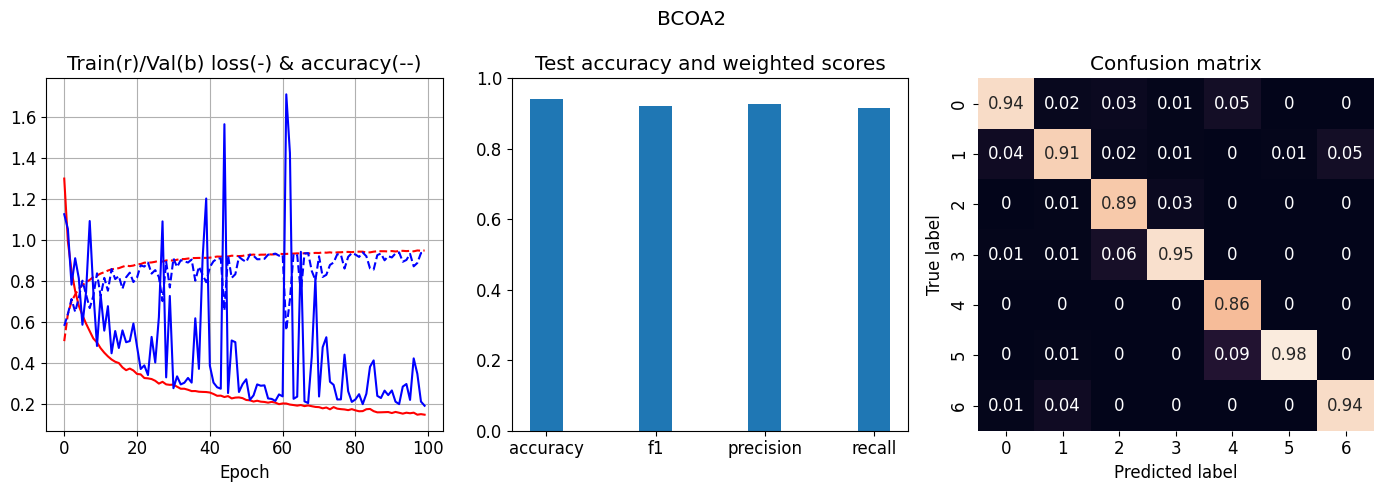

In [29]:
# We can plot the training/validation curves and task 1 results
epgs.plot_train_result()

In [14]:
# Write training log 
epgs.write_train_log()

In [40]:
# Save checkpoint
epgs.save_checkpoint(name = 'cnn1d.BCOA2.json')

Parameters saved to ./checkpoints/cnn1d/cnn1d.BCOA2.json.


## Load a pretrained model

In [32]:
# Get config
from utils.configs_utils import process_config
config = process_config('cnn1d.combined_data.256.json')
config 

{'exp_name': 'combined_data',
 'dataset_name': 99,
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'cnn1d',
 'method': 'raw',
 'scale': True,
 'outlier_filter': False,
 'optimizer': 'Adam',
 'n_epochs': 100,
 'lr': 0.0001,
 'batch_size': 256,
 'scope': 1,
 'data_path': '../data',
 'device': 'cuda',
 'timestamp': '2024-06-11 15:45:07'}

In [34]:
epgs = EPGS(config)
# load a trained model
cp = 'cnn1d.BCOA2.json'
epgs.load_checkpoint(cp)

Loading complete.


In [35]:
# predict 
pred_ana = epgs.segment(recording_name='BCOA2.test_BCOA-Wheat_01-15-18-day-ch3')

Overlap rate: 0.8590714299107152


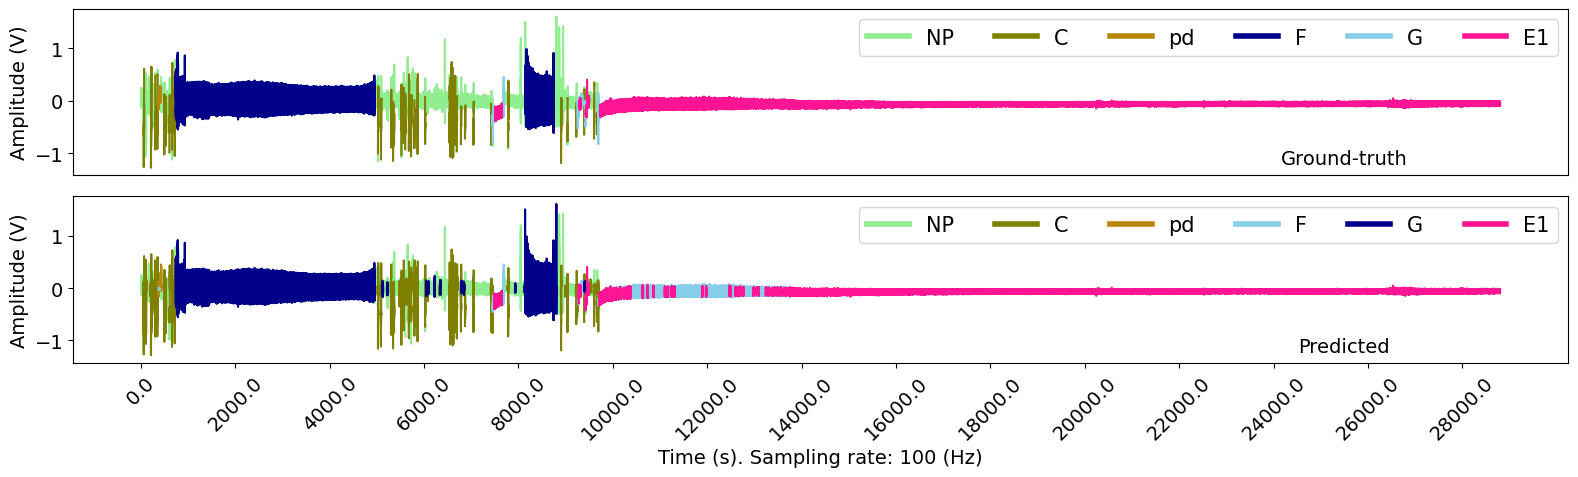

In [63]:
# plot 
print('Overlap rate:',epgs.overlap_rate)
epgs.plot_segmentation(which = 'pred_vs_gt', savefig = False, name = 'BCOA2.test_BCOA-Wheat_01-15-18-day-ch3')

In [41]:
# save analysis file 
epgs.save_analysis()

Analysis saved to ./prediction/ANA/Untitled_3.ANA


# EPGSegmentML

Support XGB, RF, LogReg, SVC

In [14]:
# Get config
from utils.configs_utils import process_config

config = process_config('XGB.soybeanAphid.wavelet.json')
config 

{'exp_name': 'Soybean_Aphid',
 'dataset_name': 'soybeanAphid',
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'XGB',
 'method': 'wavelet',
 'scale': True,
 'outlier_filter': False,
 'n_epochs': 100,
 'scope': 1,
 'data_path': '../data',
 'device': 'cpu',
 'timestamp': '2024-08-09 14:38:08'}

In [18]:
from dataset_utils.MLdatagenerator import read_dataset_from_config
from models.SegmentationML import EPGSegmentML

In [19]:
# Call the trainer
epg = EPGSegmentML(config)

Loading data ...


100%|██████████| 32/32 [00:24<00:00,  1.29it/s]

Done! Elapsed: 24.881079100014176 s


In [39]:
# Generate training data
# Feature calculation may takes a long time (About 10 minutes for 32 recordings)
# After that, the features matrix will be saved so that you will not have to calculate it again
epg.get_traindata()

Generating sliding windows ...


100%|██████████| 32/32 [00:02<00:00, 13.18it/s]


Total: 32 recordings
Signal processing method: raw | Scale: True
Class distribution (label:ratio): 1: 0.31, 2: 0.22, 4: 0.01, 5: 0.08, 6: 0.04, 7: 0.14, 8: 0.2
Labels map (from:to): {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}
Computing training features matrices ...


100%|██████████| 90183/90183 [09:12<00:00, 163.19it/s]


Computing testing features matrices ...


100%|██████████| 22546/22546 [02:19<00:00, 161.99it/s]


Dataset soybeanAphid. Elapsed computation time: 692.8006565000396
Saving datasets to .csv ...


FileNotFoundError: [Errno 2] No such file or directory: '../data/log/features_computation_time.txt'

In [41]:
# Read the training datasets
import pandas as pd

def read_dataset_csv(dataset_name, data_path = '../data/dataML'):
    columns = []
    for i in range(4):
        columns += [f'n5_{i}', f'n25_{i}', f'n75_{i}', f'n95_{i}', f'median_{i}', 
                    f'mean_{i}', f'std_{i}', f'var_{i}', f'rms_{i}', f'sk_{i}', f'zcr_{i}', f'en_{i}', f'perm_en_{i}']
    X_train = pd.read_csv(f'{data_path}/Data_{dataset_name}_train.csv',header = None)
    X_test = pd.read_csv(f'{data_path}/Data_{dataset_name}_test.csv',header = None)
    y_train =  pd.read_csv(f'{data_path}/Label_{dataset_name}_train.csv',header = None)
    y_test =  pd.read_csv(f'{data_path}/Label_{dataset_name}_test.csv',header = None)
    
    X_train.columns = columns
    X_test.columns = columns
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = read_dataset_csv(config['dataset_name'])

In [42]:
# Training
epg.fit(X_train, y_train)

Training...
Finished training. Elapsed time: 20.741 (s)


In [43]:
# Task 1 evaluation
pred = epg.predict(X_test, y_test)

Predicting ...
Accuracy: 0.9525, f1: 0.9165
Finished testing.


In [47]:
# Task 2 evaluation (segmentation)
pred_ana = epg.segment('Soybean.test_SBA-Rag5_6-10-2016-ch8')
epg.save_analysis()

Generating segmentation ...


100%|██████████| 2812/2812 [00:17<00:00, 158.15it/s]


Overlapping rate: 0.8964878472222222


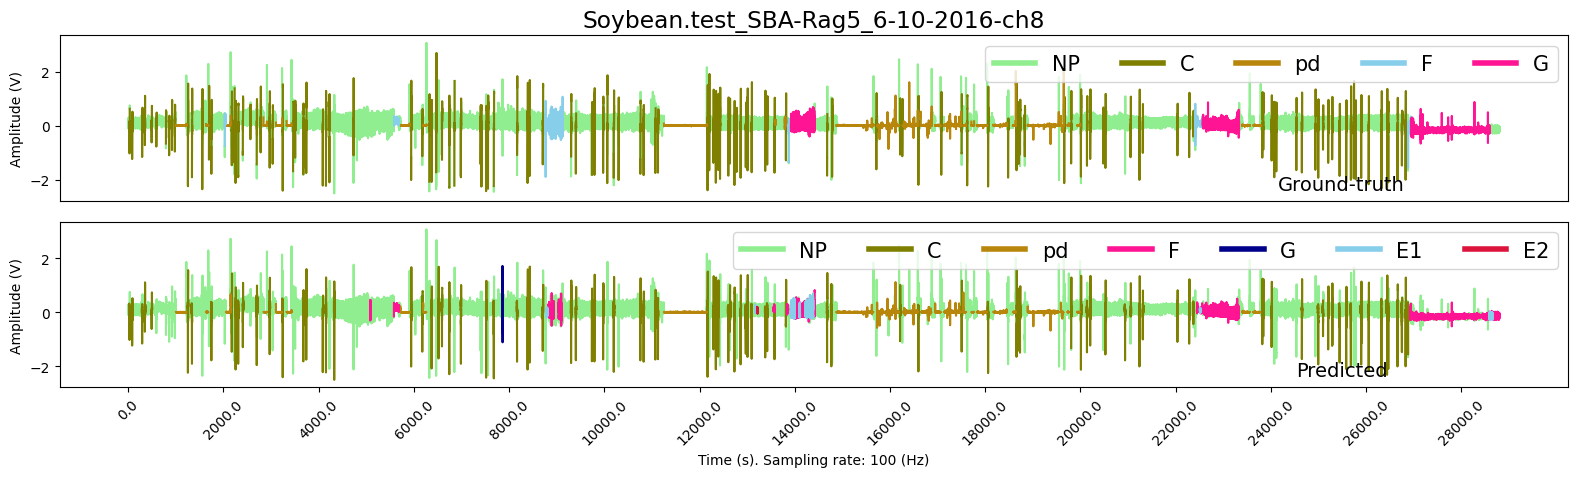

In [48]:
epg.plot_segmentation(which = 'pred_vs_gt')